In [14]:
import sqlite3
import pandas as pd
from functools import reduce
from string import punctuation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans, KMeans, Birch
from sklearn.metrics import silhouette_score
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns
import re
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.cluster import v_measure_score, homogeneity_score, completeness_score

prev_date = "datetime('2019-01-12 23:59:59')"
next_date = "datetime('2019-01-14 00:00:01')"
conn = sqlite3.connect("news.db")
articles = pd.read_sql_query("select * from allNews where published_at > " + prev_date + "and published_at < " + next_date, conn)

In [15]:
articles = articles.drop_duplicates('description')
articles = articles[~articles['description'].isnull()]
articles = articles[(articles.description.map(len) > 40)]
articles.reset_index(inplace=True, drop=True)

In [16]:
stop_words = []

f = open('./stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

In [17]:
stop = list(stopwords.words('english'))

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def tokenizer(text):
    stemmer = PorterStemmer()
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop + list(punctuation)) , tokens))
    tokens = list(map(lambda token: stemmer.stem(token), tokens))
    return tokens

In [18]:
articles['tokens'] = (articles.description + ' ' + articles.title).apply(lambda d: tokenizer(d))

In [20]:
vectorizer = TfidfVectorizer(min_df=0, max_features=1000, analyzer='word', ngram_range=(1,2), stop_words='english')
vec_matrix = vectorizer.fit_transform(list(articles['tokens'].map(lambda tokens: ' '.join(tokens))))
vec_matrix.shape

(298, 1000)

In [7]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']
 
tfidf.sort_values(by=['tfidf'], ascending=False).head(50)
tfidf.to_sql("kabotar", conn, if_exists="replace")

In [8]:
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vec_matrix)

svd_tfidf.shape

(631, 50)

In [9]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
print(tsne_tfidf.shape)
tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
tsne_tfidf_df.columns = ['x', 'y']
tsne_tfidf_df['title'] = articles['title']
tsne_tfidf_df['description'] = articles['description']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 631 samples in 0.004s...
[t-SNE] Computed neighbors for 631 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 631 / 631
[t-SNE] Mean sigma: 0.105196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.075165
[t-SNE] KL divergence after 500 iterations: 1.031846
(631, 2)


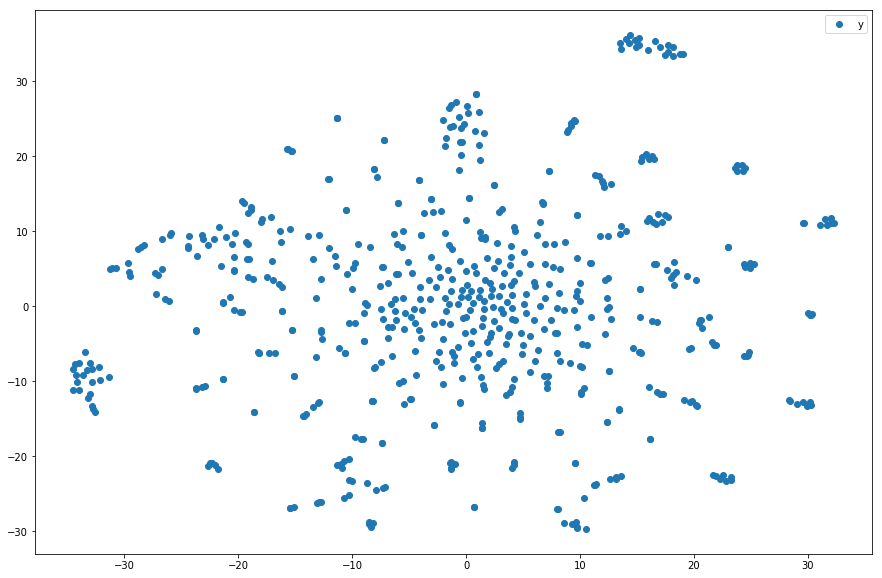

In [10]:
plt.figure(1, figsize=(15, 10))
plt.margins(0.05) # Optional, just adds 5% padding to the autoscaling
plt.plot(tsne_tfidf_df.x, tsne_tfidf_df.y, marker='o', linestyle='')
plt.legend()
plt.show()

In [113]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

output_file("boom.html")
plot_tfidf = bp.figure(plot_width=1200, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

plot_tfidf.scatter(x='x', y= 'y', 
                   legend='News', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Title": "@title", "Description":"@description"}

show(plot_tfidf)

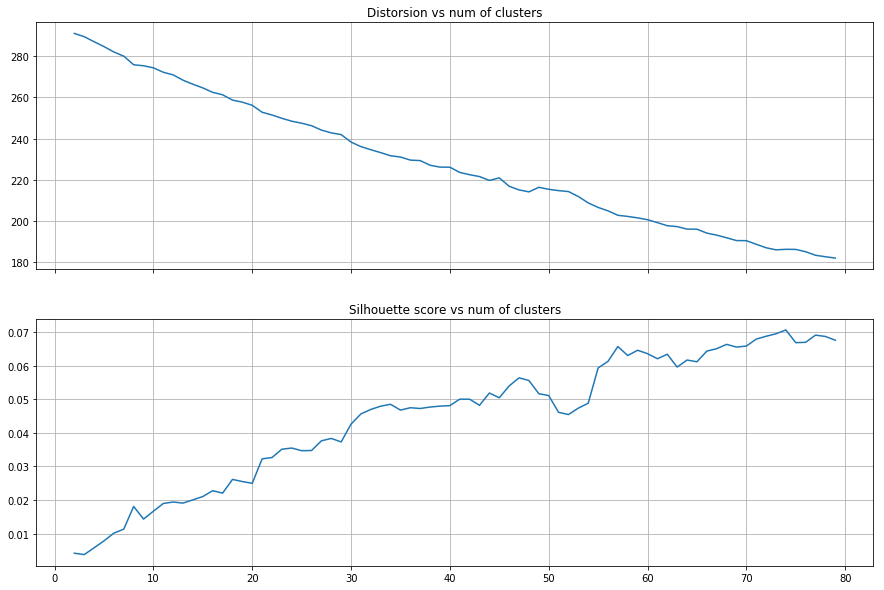

In [16]:
distorsions = []
sil_scores = []
k_max = 80
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42,  
                         init_size=1000, verbose=False, max_iter=1000)
    kmeans_model.fit(vec_matrix)
    sil_score = silhouette_score(vec_matrix, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)
    
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

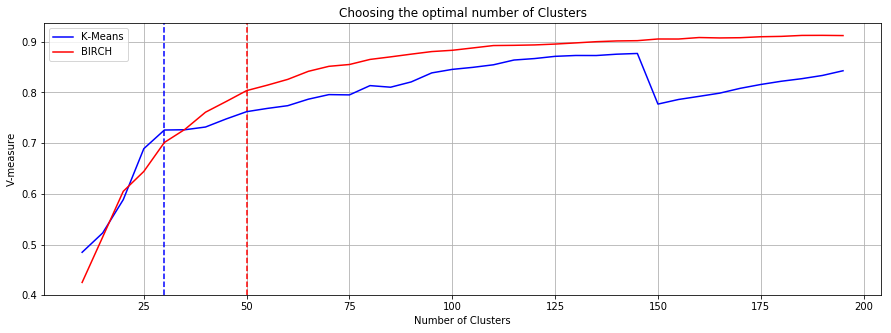

In [24]:
num_clusters = np.arange(10,200,5)
v_measure = []
b_measure = []

for num in num_clusters:
    kmeans_model = MiniBatchKMeans(n_clusters=num, init='k-means++', n_init=1, random_state=42,                       
                             init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(vec_matrix)
    kmeans_clusters = kmeans.predict(vec_matrix)
    kmeans_distances = kmeans.transform(vec_matrix)
    
    b_model = Birch(n_clusters=int(num))
    b = b_model.fit(vec_matrix)
    b_clusters = b.predict(vec_matrix)

    v_measure.append(v_measure_score(articles['orig_cluster'], kmeans_clusters))
    b_measure.append(v_measure_score(articles['orig_cluster'], b_clusters))
    
fig = plt.figure(figsize=(15, 5))
plt.axvline(30, color='blue', linestyle="dashed")
plt.axvline(50, color='red', linestyle="dashed")
plt.title('Choosing the optimal number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('V-measure')
plt.grid(True)
plt.plot(num_clusters, v_measure, label="K-Means", color="blue")
plt.plot(num_clusters, b_measure, label="BIRCH", color="red")
plt.legend(loc='best')
plt.show()

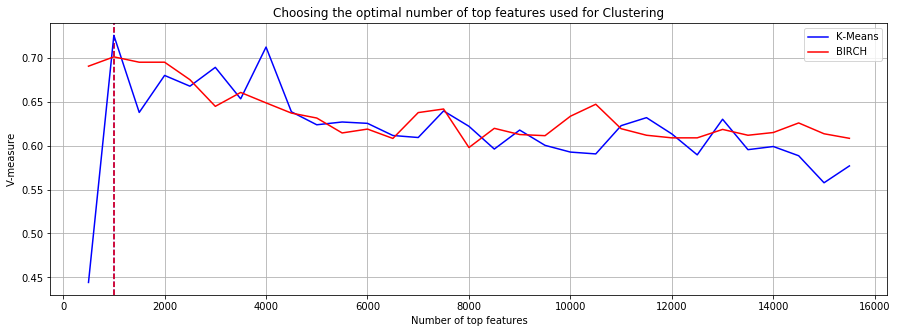

In [26]:
num_clusters = 30
max_features = np.arange(500,16000,500)
v_measure = []
b_measure = []

for features in max_features:
    vectorizer = TfidfVectorizer(min_df=0, max_features=features, analyzer='word', ngram_range=(1,2), stop_words='english')
    vec_matrix = vectorizer.fit_transform(list(articles['tokens'].map(lambda tokens: ' '.join(tokens))))
    
    kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                                 init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(vec_matrix)
    kmeans_clusters = kmeans.predict(vec_matrix)
    kmeans_distances = kmeans.transform(vec_matrix)
    
    b_model = Birch(n_clusters=num_clusters)
    b = b_model.fit(vec_matrix)
    b_clusters = b.predict(vec_matrix)

    v_measure.append(v_measure_score(articles['orig_cluster'], kmeans_clusters))
    b_measure.append(v_measure_score(articles['orig_cluster'], b_clusters))
    
fig = plt.figure(figsize=(15, 5))
plt.axvline(1000, color='blue', linestyle="dashed")
plt.axvline(1000, color='red', linestyle="dashed")
plt.title('Choosing the optimal number of top features used for Clustering')
plt.xlabel('Number of top features')
plt.ylabel('V-measure')
plt.grid(True)
plt.plot(max_features, v_measure, label="K-Means", color="blue")
plt.plot(max_features, b_measure, label="BIRCH", color="red")
plt.legend(loc='best')
plt.show()

In [11]:
num_clusters = 30
features = 1000
vectorizer = TfidfVectorizer(min_df=0, max_features=features, analyzer='word', ngram_range=(1,2), stop_words='english')
vec_matrix = vectorizer.fit_transform(list(articles['tokens'].map(lambda tokens: ' '.join(tokens))))
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                             init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(vec_matrix)
kmeans_clusters = kmeans.predict(vec_matrix)
kmeans_distances = kmeans.transform(vec_matrix)
print(v_measure_score(articles['orig_cluster'], kmeans_clusters))

0.7258290707629171


In [84]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
#keywords_df

In [85]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['cluster'] = kmeans_df['cluster'].map(str)
kmeans_df['description'] = articles['description']
kmeans_df['title'] = articles['title']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 298 samples in 0.000s...
[t-SNE] Computed neighbors for 298 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 298 / 298
[t-SNE] Mean sigma: 0.032385
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.505356
[t-SNE] KL divergence after 500 iterations: 0.614967


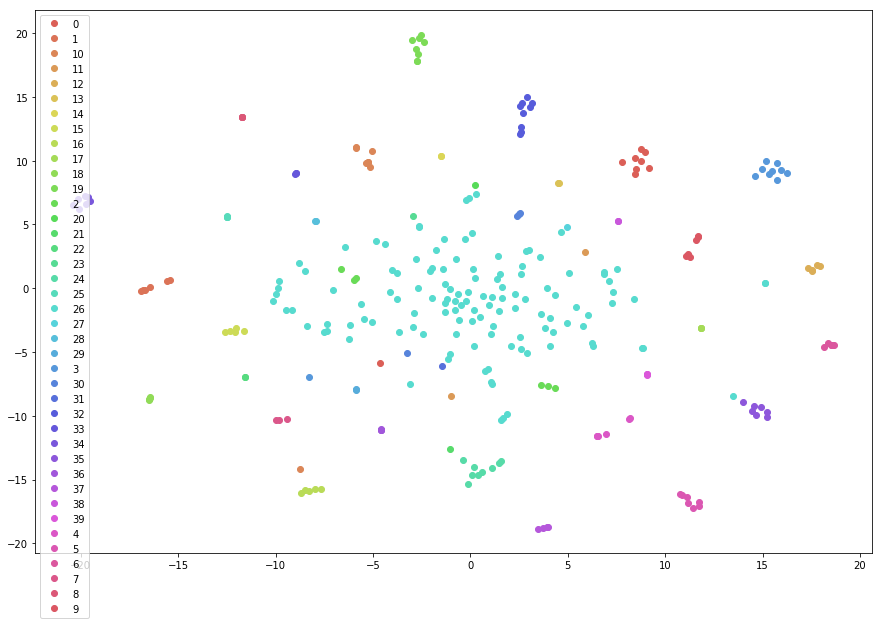

In [111]:
sns.set_palette(sns.color_palette("hls", num_clusters))
groups = kmeans_df.groupby('cluster')
fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

cluster_news = []
for name, group in groups:
    min_dist = 100
    min_ind = 0
    for ind in group.index:
        if kmeans_distances[ind][int(name)] < min_dist:
            min_dist = kmeans_distances[ind][int(name)]
            min_ind = ind
            
    cluster_news.append(articles.iloc[min_ind])
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.show()

#cluster_news

In [114]:
reset_output()
output_file("boom.html")
plot_kmeans = bp.figure(plot_width=1200, plot_height=600, title="KMeans clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category20'][20] + d3['Category20b'][20] 
color_map = bmo.CategoricalColorMapper(factors=kmeans_df['cluster'].unique(), palette=palette)

plot_kmeans.scatter('x', 'y', source=kmeans_df, 
                    color={'field': 'cluster', 'transform': color_map}, 
                    legend='Cluster')
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"Title": "@title", "Description": "@description", "Cluster": "@cluster"}

show(plot_kmeans)

In [27]:
num_clusters = 30
features = 1000
vectorizer = TfidfVectorizer(min_df=0, max_features=features, analyzer='word', ngram_range=(1,2), stop_words='english')
vec_matrix = vectorizer.fit_transform(list(articles['tokens'].map(lambda tokens: ' '.join(tokens))))

ms_model = Birch(n_clusters=num_clusters)
ms = ms_model.fit(vec_matrix)
ms_clusters = ms.predict(vec_matrix)
print(v_measure_score(articles['orig_cluster'], ms_clusters))

0.7013169583859427


In [158]:
def get_document_topic_matrix(corpus, num_topics=best_model.num_topics):
    matrix = []
    for row in tqdm_notebook(corpus):
        output = np.zeros(num_topics)
        doc_proba = best_model[row][0]
        for doc, proba in doc_proba:
            output[doc] = proba
        matrix.append(output)
    matrix = np.array(matrix)
    return matrix

In [159]:
matrix = get_document_topic_matrix(corpus)

In [160]:
doc_topic = best_model.get_document_topics(corpus)
lda_keys = []
for i, desc in enumerate(articles['description']):
    lda_keys.append(np.argmax(matrix[i, :]))
    
print(v_measure_score(articles['orig_cluster'], lda_keys))

0.6610599049586807


In [161]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_lda = tsne_model.fit_transform(matrix)
lda_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(str)
lda_df['description'] = articles['description']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 298 samples in 0.004s...
[t-SNE] Computed neighbors for 298 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 298 / 298
[t-SNE] Mean sigma: 0.629194
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.064941
[t-SNE] KL divergence after 500 iterations: 0.407929


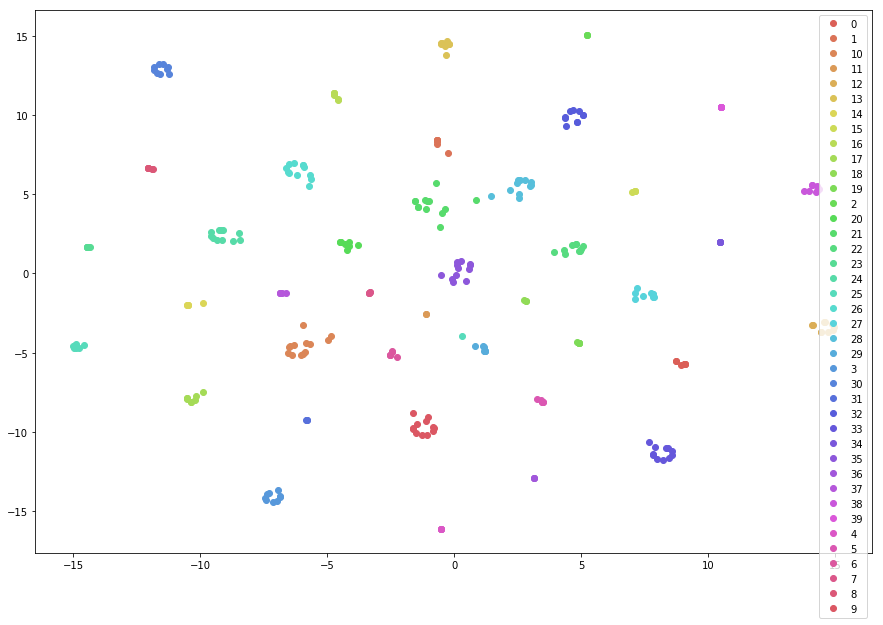

In [162]:
sns.set_palette(sns.color_palette("hls", num_clusters))
groups = lda_df.groupby('topic')
fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.show()